In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertModel, BertConfig
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    precision_recall_curve, auc, confusion_matrix
)
from sklearn.calibration import calibration_curve
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy.stats import chi2_contingency, ttest_ind

# 1. Load Dataset and Preprocessing
df = pd.read_csv('filtered_structured_first_icu_stays.csv')

# Encode disease codes as numerical values
unique_diseases = df['hadm_id'].unique()
disease_mapping = {d: i for i, d in enumerate(unique_diseases)}
df['mapped_disease_id'] = df['hadm_id'].map(disease_mapping)

# Function to categorize ethnicity into five main categories
def categorize_ethnicity(ethnicity):
    if pd.isna(ethnicity):  
        return 'Other'
    ethnicity = ethnicity.upper().strip() 
    # White category
    if ethnicity in [
        'WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 
        'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN']:
        return 'White'
    elif any(keyword in ethnicity for keyword in ['WHITE', 'EUROPEAN', 'RUSSIAN', 'BRAZILIAN', 'PORTUGUESE']):
        return 'White'
    # Black category
    elif ethnicity in [
        'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN', 
        'BLACK/AFRICAN', 'CARIBBEAN ISLAND']:
        return 'Black'
    elif any(keyword in ethnicity for keyword in ['BLACK', 'AFRICAN', 'CAPE VERDEAN', 'HAITIAN']):
        return 'Black'
    # Hispanic category
    elif ethnicity in [
        'HISPANIC OR LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 
        'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - MEXICAN']:
        return 'Hispanic'
    elif any(keyword in ethnicity for keyword in [
        'HISPANIC', 'LATINO', 'GUATEMALAN', 'PUERTO RICAN', 'DOMINICAN', 
        'SALVADORAN', 'COLOMBIAN', 'MEXICAN', 'CUBAN', 'HONDURAN']):
        return 'Hispanic'
    # Asian category
    elif ethnicity in ['ASIAN', 'ASIAN - CHINESE', 'ASIAN - INDIAN']:
        return 'Asian'
    elif any(keyword in ethnicity for keyword in [
        'ASIAN', 'CHINESE', 'JAPANESE', 'VIETNAMESE', 'FILIPINO', 
        'THAI', 'KOREAN', 'CAMBODIAN', 'ASIAN INDIAN']):
        return 'Asian'
    # Other category
    else:
        return 'Other'

# Create ethnicity columns (if not already present in the original CSV)
if 'categorized_ethnicity' not in df.columns:
    df['categorized_ethnicity'] = df['ETHNICITY'].apply(categorize_ethnicity)
if 'categorized_ethnicity_code' not in df.columns:
    df['categorized_ethnicity_code'] = df['categorized_ethnicity'].astype('category').cat.codes


# Convert time columns to datetime
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'], errors='coerce')

# Calculate time differences in hours
df['time_to_discharge'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds() / 3600
df['time_to_death'] = (df['DEATHTIME'] - df['ADMITTIME']).dt.total_seconds() / 3600

# Encode 'GENDER' as numerical values before filtering the data
df['GENDER'] = df['GENDER'].astype('category').cat.codes

# Encode 'INSURANCE' as numerical values before filtering the data
df['INSURANCE'] = df['INSURANCE'].astype('category').cat.codes

# Filter records up to 6 hours before discharge or death
df_filtered = df[
    (
        (df['time_to_discharge'] > 6) & 
        (df['short_term_mortality'] == 0) 
    ) | 
    (
        (df['time_to_death'] > 6) & 
        (df['short_term_mortality'] == 1)
    )
]

# Function to compute class weights using the Inverse of Number of Samples (INS)
def compute_class_weights(df, label_column):
    class_counts = df[label_column].value_counts().sort_index()
    total_samples = len(df)
    class_weights = total_samples / (class_counts * len(class_counts))
    return class_weights

# Compute class weights for each outcome using INS
class_weights_mortality = compute_class_weights(df_filtered, 'short_term_mortality')
class_weights_readmission = compute_class_weights(df_filtered, 'readmission_within_30_days')

# Convert class weights to tensors for PyTorch loss functions
class_weights_tensor_mortality = torch.tensor(class_weights_mortality.values, dtype=torch.float).to('cpu')
class_weights_tensor_readmission = torch.tensor(class_weights_readmission.values, dtype=torch.float).to('cpu')

# Function to count positive and negative cases
def count_positive_negative_cases(df, columns):
    for column in columns:
        positive_cases = df[column].sum()
        negative_cases = len(df) - positive_cases
        print(f"{column} - Positive Cases: {positive_cases}, Negative Cases: {negative_cases}")

# Define outcome columns
outcome_columns = ['short_term_mortality', 'readmission_within_30_days']

# Count positive and negative cases for each outcome
count_positive_negative_cases(df_filtered, outcome_columns)

short_term_mortality - Positive Cases: 3315, Negative Cases: 30377
readmission_within_30_days - Positive Cases: 3031, Negative Cases: 30661


In [4]:
# 2. Prepare Sequences for Model Input
def prepare_sequences(df):
    patients = df['subject_id'].unique()
    sequences = []
    labels = []
    patient_ids = []

    for patient in patients:
        patient_data = df[df['subject_id'] == patient].sort_values(by='ADMITTIME')
        
        age_sequence = patient_data['age'].tolist()
        disease_sequence = patient_data['mapped_disease_id'].tolist()
        admission_loc_sequence = patient_data['FIRST_WARDID'].tolist()  
        discharge_loc_sequence = patient_data['LAST_WARDID'].tolist()  
        segment_sequence = [0 if i % 2 == 0 else 1 for i in range(len(age_sequence))]

        short_term_mortality_label = patient_data['short_term_mortality'].max()
        readmission_label = patient_data['readmission_within_30_days'].max()

        sequences.append({
            'age': age_sequence,
            'diseases': disease_sequence,
            'admission_loc': admission_loc_sequence,
            'discharge_loc': discharge_loc_sequence,
            'segment': segment_sequence,
            'gender': patient_data['GENDER'].tolist(),
            'ethnicity': patient_data['categorized_ethnicity_code'].tolist(),
            'insurance': patient_data['INSURANCE'].tolist()
        })
        labels.append([short_term_mortality_label, readmission_label])
        patient_ids.append(patient)

    return sequences, labels, patient_ids

sequences, labels, patient_ids = prepare_sequences(df_filtered)

# Tokenize sequences and encode them
input_ids = []
age_ids = []
segment_ids = []
admission_loc_ids = []
discharge_loc_ids = []
gender_ids = []
ethnicity_ids = []
insurance_ids = []

for seq in sequences:
    token_ids = seq['diseases']
    age_sequence = seq['age']
    segment_sequence = seq['segment']
    admission_loc_sequence = seq['admission_loc']
    discharge_loc_sequence = seq['discharge_loc']
    gender_sequence = seq['gender']
    ethnicity_sequence = seq['ethnicity']
    insurance_sequence = seq['insurance']
    
    input_ids.append(token_ids)
    age_ids.append(age_sequence)
    segment_ids.append(segment_sequence)
    admission_loc_ids.append(admission_loc_sequence)
    discharge_loc_ids.append(discharge_loc_sequence)
    gender_ids.append(gender_sequence)
    ethnicity_ids.append(ethnicity_sequence)
    insurance_ids.append(insurance_sequence)

# Determine maximum sequence length and pad all sequences
max_len = max(len(seq) for seq in input_ids)

def pad_sequences(sequences, max_len):
    return [seq + [0] * (max_len - len(seq)) for seq in sequences]

input_ids_padded = pad_sequences(input_ids, max_len)
age_ids_padded = pad_sequences(age_ids, max_len)
segment_ids_padded = pad_sequences(segment_ids, max_len)
admission_loc_ids_padded = pad_sequences(admission_loc_ids, max_len)
discharge_loc_ids_padded = pad_sequences(discharge_loc_ids, max_len)
gender_ids_padded = pad_sequences(gender_ids, max_len)
ethnicity_ids_padded = pad_sequences(ethnicity_ids, max_len)
insurance_ids_padded = pad_sequences(insurance_ids, max_len)

# Convert to PyTorch tensors
input_ids_tensor = torch.tensor(input_ids_padded, dtype=torch.long)
age_ids_tensor = torch.tensor(age_ids_padded, dtype=torch.long)
segment_ids_tensor = torch.tensor(segment_ids_padded, dtype=torch.long)
admission_loc_ids_tensor = torch.tensor(admission_loc_ids_padded, dtype=torch.long)
discharge_loc_ids_tensor = torch.tensor(discharge_loc_ids_padded, dtype=torch.long)
gender_ids_tensor = torch.tensor(gender_ids_padded, dtype=torch.long)
ethnicity_ids_tensor = torch.tensor(ethnicity_ids_padded, dtype=torch.long)
insurance_ids_tensor = torch.tensor(insurance_ids_padded, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.float)

# Creating dataset and dataloader
dataset = TensorDataset(
    input_ids_tensor, age_ids_tensor, segment_ids_tensor,
    admission_loc_ids_tensor, discharge_loc_ids_tensor, 
    gender_ids_tensor, ethnicity_ids_tensor, insurance_ids_tensor, 
    labels_tensor
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
# 3. Define BEHRT Model
class BEHRTModel(nn.Module):
    def __init__(self, num_diseases, num_ages, num_segments, num_admission_locs, num_discharge_locs, 
                 num_genders, num_ethnicities, num_insurances, hidden_size=768):
        super(BEHRTModel, self).__init__()

        config = BertConfig(
            vocab_size=num_diseases + num_ages + num_segments + num_admission_locs + num_discharge_locs + 2,
            hidden_size=hidden_size,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            max_position_embeddings=512,
            type_vocab_size=2,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1
        )

        self.bert = BertModel(config)
        self.age_embedding = nn.Embedding(num_ages, hidden_size)
        self.segment_embedding = nn.Embedding(num_segments, hidden_size)
        self.admission_loc_embedding = nn.Embedding(num_admission_locs, hidden_size)
        self.discharge_loc_embedding = nn.Embedding(num_discharge_locs, hidden_size)
        
        # Add embeddings for new demographic features
        self.gender_embedding = nn.Embedding(num_genders, hidden_size)
        self.ethnicity_embedding = nn.Embedding(num_ethnicities, hidden_size)
        self.insurance_embedding = nn.Embedding(num_insurances, hidden_size)

        # Three classifiers for three different binary target variables
        self.classifier_mortality = nn.Linear(hidden_size, 1)
        self.classifier_readmission = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, age_ids, segment_ids, admission_loc_ids, discharge_loc_ids, 
                gender_ids, ethnicity_ids, insurance_ids, attention_mask=None):
        
        # Clamp IDs to valid ranges
        age_ids = torch.clamp(age_ids, min=0, max=self.age_embedding.num_embeddings - 1)
        segment_ids = torch.clamp(segment_ids, min=0, max=self.segment_embedding.num_embeddings - 1)
        admission_loc_ids = torch.clamp(admission_loc_ids, min=0, max=self.admission_loc_embedding.num_embeddings - 1)
        discharge_loc_ids = torch.clamp(discharge_loc_ids, min=0, max=self.discharge_loc_embedding.num_embeddings - 1)
        gender_ids = torch.clamp(gender_ids, min=0, max=self.gender_embedding.num_embeddings - 1)
        ethnicity_ids = torch.clamp(ethnicity_ids, min=0, max=self.ethnicity_embedding.num_embeddings - 1)
        insurance_ids = torch.clamp(insurance_ids, min=0, max=self.insurance_embedding.num_embeddings - 1)

        # Forward pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # Get embeddings
        age_embeds = self.age_embedding(age_ids)
        segment_embeds = self.segment_embedding(segment_ids)
        admission_loc_embeds = self.admission_loc_embedding(admission_loc_ids)
        discharge_loc_embeds = self.discharge_loc_embedding(discharge_loc_ids)
        gender_embeds = self.gender_embedding(gender_ids)
        ethnicity_embeds = self.ethnicity_embedding(ethnicity_ids)
        insurance_embeds = self.insurance_embedding(insurance_ids)

        # Combine embeddings
        combined_output = (sequence_output + age_embeds + segment_embeds + 
                           admission_loc_embeds + discharge_loc_embeds + 
                           gender_embeds + ethnicity_embeds + insurance_embeds)

        # Classifier outputs
        logits_mortality = self.classifier_mortality(combined_output[:, 0, :])
        logits_readmission = self.classifier_readmission(combined_output[:, 0, :])

        return logits_mortality, logits_readmission

# Initialize the model
num_diseases = len(disease_mapping)
num_ages = df_filtered['age'].nunique()
num_segments = 2
num_admission_locs = df_filtered['FIRST_WARDID'].nunique()  # Updated
num_discharge_locs = df_filtered['LAST_WARDID'].nunique()   # Updated
num_genders = df_filtered['GENDER'].nunique()
num_ethnicities = df_filtered['categorized_ethnicity_code'].nunique()
num_insurances = df_filtered['INSURANCE'].nunique()

model = BEHRTModel(
    num_diseases=num_diseases,
    num_ages=num_ages,
    num_segments=num_segments,
    num_admission_locs=num_admission_locs,
    num_discharge_locs=num_discharge_locs,
    num_genders=num_genders,
    num_ethnicities=num_ethnicities,
    num_insurances=num_insurances
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BEHRTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(34049, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [6]:
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
bce_loss_mortality = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_mortality[1])  
bce_loss_readmission = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_readmission[1])  


In [8]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()  
    total_loss = 0.0

    for batch in dataloader:
        input_ids, age_ids, segment_ids, admission_loc_ids, discharge_loc_ids, \
        gender_ids, ethnicity_ids, insurance_ids, labels = batch

        input_ids = input_ids.to(device)
        age_ids = age_ids.to(device)
        segment_ids = segment_ids.to(device)
        admission_loc_ids = admission_loc_ids.to(device)
        discharge_loc_ids = discharge_loc_ids.to(device)
        gender_ids = gender_ids.to(device)
        ethnicity_ids = ethnicity_ids.to(device)
        insurance_ids = insurance_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  

        # Forward pass through the model
        logits_mortality, logits_readmission = model(
            input_ids=input_ids, 
            age_ids=age_ids, 
            segment_ids=segment_ids, 
            admission_loc_ids=admission_loc_ids, 
            discharge_loc_ids=discharge_loc_ids,
            gender_ids=gender_ids,
            ethnicity_ids=ethnicity_ids,
            insurance_ids=insurance_ids
        )

        # Compute weighted binary cross-entropy losses for mortality and readmission
        loss_mortality = bce_loss_mortality(logits_mortality, labels[:, 0].unsqueeze(1))
        loss_readmission = bce_loss_readmission(logits_readmission, labels[:, 1].unsqueeze(1))

        # Combine losses
        total_loss_batch = loss_mortality + loss_readmission
        total_loss_batch.backward()  

        optimizer.step()  
        total_loss += total_loss_batch.item()  

    scheduler.step(total_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/10 - Total Loss: 2098.1035
Epoch 2/10 - Total Loss: 1973.9915
Epoch 3/10 - Total Loss: 1878.2281
Epoch 4/10 - Total Loss: 1626.7800
Epoch 5/10 - Total Loss: 1226.9029
Epoch 6/10 - Total Loss: 1184.2455
Epoch 7/10 - Total Loss: 1144.9641
Epoch 8/10 - Total Loss: 1104.5070
Epoch 9/10 - Total Loss: 1097.5079
Epoch 10/10 - Total Loss: 1100.7390


In [13]:
# 5. Evaluation Function

def evaluate_model(model, dataloader, device):
    model.eval()  
    all_labels = []
    all_logits = {'mortality': [], 'readmission': []}
    all_predictions = {'mortality': [], 'readmission': []}

    with torch.no_grad():
        for batch in dataloader:
            input_ids, age_ids, segment_ids, admission_loc_ids, discharge_loc_ids, \
            gender_ids, ethnicity_ids, insurance_ids, labels = batch
            input_ids = input_ids.to(device)
            age_ids = age_ids.to(device)
            segment_ids = segment_ids.to(device)
            admission_loc_ids = admission_loc_ids.to(device)
            discharge_loc_ids = discharge_loc_ids.to(device)
            gender_ids = gender_ids.to(device)
            ethnicity_ids = ethnicity_ids.to(device)
            insurance_ids = insurance_ids.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            logits_mortality, logits_readmission = model(
                input_ids=input_ids, 
                age_ids=age_ids, 
                segment_ids=segment_ids, 
                admission_loc_ids=admission_loc_ids, 
                discharge_loc_ids=discharge_loc_ids,
                gender_ids=gender_ids,
                ethnicity_ids=ethnicity_ids,
                insurance_ids=insurance_ids
            )

            # Collect logits and labels
            all_logits['mortality'].append(logits_mortality.cpu().numpy())
            all_logits['readmission'].append(logits_readmission.cpu().numpy())

            all_labels.append(labels.cpu().numpy())

            # Convert logits to binary predictions using a threshold of 0.5
            pred_mortality = (torch.sigmoid(logits_mortality) > 0.5).cpu().numpy().astype(int)
            pred_readmission = (torch.sigmoid(logits_readmission) > 0.5).cpu().numpy().astype(int)

            # Append predictions
            all_predictions['mortality'].append(pred_mortality)
            all_predictions['readmission'].append(pred_readmission)

    # Concatenate all collected data
    all_labels = np.concatenate(all_labels, axis=0)
    all_logits['mortality'] = np.concatenate(all_logits['mortality'], axis=0)
    all_logits['readmission'] = np.concatenate(all_logits['readmission'], axis=0)
    all_predictions['mortality'] = np.concatenate(all_predictions['mortality'], axis=0)
    all_predictions['readmission'] = np.concatenate(all_predictions['readmission'], axis=0)

    # Compute AUROC for each task
    auroc_mortality = roc_auc_score(all_labels[:, 0], all_logits['mortality'])
    auroc_readmission = roc_auc_score(all_labels[:, 1], all_logits['readmission'])

    # Compute AUPRC for each task
    precision_mortality, recall_mortality, _ = precision_recall_curve(all_labels[:, 0], all_logits['mortality'])
    auprc_mortality = auc(recall_mortality, precision_mortality)

    precision_readmission, recall_readmission, _ = precision_recall_curve(all_labels[:, 1], all_logits['readmission'])
    auprc_readmission = auc(recall_readmission, precision_readmission)

    # Precision, Recall, and F1 scores for each target
    precision_mortality_score = precision_score(all_labels[:, 0], all_predictions['mortality'])
    recall_mortality_score = recall_score(all_labels[:, 0], all_predictions['mortality'])
    f1_mortality = f1_score(all_labels[:, 0], all_predictions['mortality'])

    precision_readmission_score = precision_score(all_labels[:, 1], all_predictions['readmission'])
    recall_readmission_score = recall_score(all_labels[:, 1], all_predictions['readmission'])
    f1_readmission = f1_score(all_labels[:, 1], all_predictions['readmission'])

    # Return evaluation results
    return {
        'logits': all_logits,
        'predictions': all_predictions,
        'labels': all_labels,
        'auroc': {
            'mortality': auroc_mortality,
            'readmission': auroc_readmission
        },
        'auprc': {
            'mortality': auprc_mortality,
            'readmission': auprc_readmission
        },
        'precision': {
            'mortality': precision_mortality_score,
            'readmission': precision_readmission_score
        },
        'recall': {
            'mortality': recall_mortality_score,
            'readmission': recall_readmission_score
        },
        'f1': {
            'mortality': f1_mortality,
            'readmission': f1_readmission
        }
    }


In [15]:
# Run evaluation
evaluation_results = evaluate_model(model, dataloader, device)
print(evaluation_results)

{'logits': {'mortality': array([[-0.88593745],
       [ 0.83649623],
       [-5.9085255 ],
       ...,
       [-6.177718  ],
       [-4.7459445 ],
       [-4.775068  ]], dtype=float32), 'readmission': array([[ 1.749784 ],
       [ 1.436299 ],
       [-5.8062353],
       ...,
       [-5.764527 ],
       [-4.769521 ],
       [-3.371783 ]], dtype=float32)}, 'predictions': {'mortality': array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]]), 'readmission': array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])}, 'labels': array([[0., 1.],
       [0., 1.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32), 'auroc': {'mortality': 0.9431074733002079, 'readmission': 0.9311529414083883}, 'auprc': {'mortality': 0.7062069423008656, 'readmission': 0.6377944569362185}, 'precision': {'mortality': 0.48469206123175507, 'readmission': 0.4526898130484548}, 'recall': {'mortality': 0.8214177978883861,

In [16]:
import numpy as np
import torch

def get_model_predictions(model, dataloader, device):
    all_predictions = {'mortality': [], 'readmission': []}
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Unpack the batch
            input_ids, age_ids, segment_ids, admission_loc_ids, discharge_loc_ids, \
            gender_ids, ethnicity_ids, insurance_ids, labels = batch
            
            # Move tensors to the appropriate device
            input_ids = input_ids.to(device)
            age_ids = age_ids.to(device)
            segment_ids = segment_ids.to(device)
            admission_loc_ids = admission_loc_ids.to(device)
            discharge_loc_ids = discharge_loc_ids.to(device)
            gender_ids = gender_ids.to(device)
            ethnicity_ids = ethnicity_ids.to(device)
            insurance_ids = insurance_ids.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            logits_mortality, logits_readmission = model(
                input_ids=input_ids, 
                age_ids=age_ids, 
                segment_ids=segment_ids, 
                admission_loc_ids=admission_loc_ids, 
                discharge_loc_ids=discharge_loc_ids, 
                gender_ids=gender_ids, 
                ethnicity_ids=ethnicity_ids,
                insurance_ids=insurance_ids
            )
            
            # Convert logits to binary predictions using a threshold of 0.5
            pred_mortality = (torch.sigmoid(logits_mortality) > 0.5).cpu().numpy().astype(int)
            pred_readmission = (torch.sigmoid(logits_readmission) > 0.5).cpu().numpy().astype(int)

            # Append predictions
            all_predictions['mortality'].extend(pred_mortality)
            all_predictions['readmission'].extend(pred_readmission)
            
            # Append true labels
            all_labels.append(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_predictions, all_labels


In [17]:
# Generate predictions from the trained model
predictions, labels = get_model_predictions(model, dataloader, device)


In [18]:
# Ensure predictions and labels are NumPy arrays
predictions['mortality'] = np.array(predictions['mortality'])
predictions['readmission'] = np.array(predictions['readmission'])
labels = np.array(labels)

In [19]:
from sklearn.metrics import confusion_matrix

def calculate_equalized_odds(labels, predictions, sensitive_attribute):
    unique_groups = np.unique(sensitive_attribute)
    equalized_odds = {}

    for group in unique_groups:
        group_idx = (sensitive_attribute == group) 
        group_labels = labels[group_idx]
        group_predictions = predictions[group_idx]

        # Confusion matrix with safeguards for missing classes
        cm = confusion_matrix(group_labels, group_predictions)
        tn, fp, fn, tp = (0, 0, 0, 0)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()

        # Compute TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  

        equalized_odds[group] = {'TPR': tpr, 'FPR': fpr}

    return equalized_odds

def calculate_equal_opportunity(labels, predictions, sensitive_attribute):
    unique_groups = np.unique(sensitive_attribute)
    equal_opportunity = {}

    for group in unique_groups:
        group_idx = (sensitive_attribute == group)
        group_labels = labels[group_idx]
        group_predictions = predictions[group_idx]

        # Confusion matrix
        cm = confusion_matrix(group_labels, group_predictions)
        tn, fp, fn, tp = (0, 0, 0, 0)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()

        # Compute TPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  

        equal_opportunity[group] = {'TPR': tpr}

    return equal_opportunity

def calculate_disparity(metric_values):
    return max(metric_values) - min(metric_values)

def evaluate_fairness(labels, predictions, sensitive_attribute):
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Calculate Equalized Odds and Equal Opportunity
    equalized_odds = calculate_equalized_odds(labels, predictions, sensitive_attribute)
    equal_opportunity = calculate_equal_opportunity(labels, predictions, sensitive_attribute)

    # Calculate Disparity for TPR and FPR
    tpr_values = [v['TPR'] for v in equalized_odds.values()]
    fpr_values = [v['FPR'] for v in equalized_odds.values()]
    disparity_tpr = calculate_disparity(tpr_values)
    disparity_fpr = calculate_disparity(fpr_values)

    return {
        'equalized_odds': equalized_odds,
        'equal_opportunity': equal_opportunity,
        'disparity': {
            'TPR': disparity_tpr,
            'FPR': disparity_fpr
        }
    }


In [20]:
# Define mappings for demographic variables
gender_mapping = {0: 'Female', 1: 'Male'}
ethnicity_mapping = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Hispanic/Latino',
    4: 'Other'
}
insurance_mapping = {0: 'Government', 1: 'Medicaid', 2: 'Medicare', 3: 'Private', 4: 'Self Pay'}

# Function to map specific ethnicity keywords to standardized categories
def map_ethnicity(ethnicity):
    ethnicity = ethnicity.upper().strip()
    if any(keyword in ethnicity for keyword in ['WHITE', 'EUROPEAN', 'RUSSIAN', 'BRAZILIAN', 'PORTUGUESE']):
        return 'White'
    elif any(keyword in ethnicity for keyword in ['BLACK', 'AFRICAN', 'CAPE VERDEAN', 'HAITIAN']):
        return 'Black'
    elif any(keyword in ethnicity for keyword in ['ASIAN', 'CHINESE', 'JAPANESE', 'VIETNAMESE', 'FILIPINO']):
        return 'Asian'
    elif any(keyword in ethnicity for keyword in ['HISPANIC', 'LATINO', 'GUATEMALAN', 'PUERTO RICAN']):
        return 'Hispanic/Latino'
    else:
        return 'Other'

# Apply mappings to the dataset
df['categorized_ethnicity'] = df['ETHNICITY'].apply(map_ethnicity)
df['categorized_ethnicity_code'] = df['categorized_ethnicity'].astype('category').cat.codes


In [21]:
# Evaluate fairness for gender
sensitive_attribute_gender = df_filtered['GENDER'].values
fairness_results_gender = evaluate_fairness(labels[:, 0], predictions['mortality'], sensitive_attribute_gender)

print("Fairness Evaluation - Gender (Male/Female):")
print(fairness_results_gender)


Fairness Evaluation - Gender (Male/Female):
{'equalized_odds': {0: {'TPR': 0.8277580071174377, 'FPR': 0.09634136828145722}, 1: {'TPR': 0.8167539267015707, 'FPR': 0.09454379769905456}}, 'equal_opportunity': {0: {'TPR': 0.8277580071174377}, 1: {'TPR': 0.8167539267015707}}, 'disparity': {'TPR': 0.01100408041586709, 'FPR': 0.0017975705824026522}}


In [22]:
# Evaluate fairness for ethnicity
sensitive_attribute_ethnicity = df_filtered['categorized_ethnicity_code'].values
fairness_results_ethnicity = evaluate_fairness(labels[:, 0], predictions['mortality'], sensitive_attribute_ethnicity)

print("\nFairness Evaluation - Ethnicity:")
print(fairness_results_ethnicity)



Fairness Evaluation - Ethnicity:
{'equalized_odds': {0: {'TPR': 0.7529411764705882, 'FPR': 0.11004126547455295}, 1: {'TPR': 0.8577235772357723, 'FPR': 0.09079550187421907}, 2: {'TPR': 0.7766990291262136, 'FPR': 0.1069364161849711}, 3: {'TPR': 0.8137651821862348, 'FPR': 0.09335248256052524}, 4: {'TPR': 0.8236279849183075, 'FPR': 0.09518676477480432}}, 'equal_opportunity': {0: {'TPR': 0.7529411764705882}, 1: {'TPR': 0.8577235772357723}, 2: {'TPR': 0.7766990291262136}, 3: {'TPR': 0.8137651821862348}, 4: {'TPR': 0.8236279849183075}}, 'disparity': {'TPR': 0.10478240076518408, 'FPR': 0.01924576360033388}}


In [23]:
# Evaluate fairness for insurance
sensitive_attribute_insurance = df_filtered['INSURANCE'].values
fairness_results_insurance = evaluate_fairness(labels[:, 0], predictions['mortality'], sensitive_attribute_insurance)

print("\nFairness Evaluation - Insurance:")
print(fairness_results_insurance)



Fairness Evaluation - Insurance:
{'equalized_odds': {0: {'TPR': 0.8478260869565217, 'FPR': 0.10953346855983773}, 1: {'TPR': 0.8264150943396227, 'FPR': 0.09076863653920432}, 2: {'TPR': 0.8109393579072532, 'FPR': 0.0945020543924868}, 3: {'TPR': 0.8341423948220065, 'FPR': 0.09587797348828764}, 4: {'TPR': 0.775, 'FPR': 0.10329670329670329}}, 'equal_opportunity': {0: {'TPR': 0.8478260869565217}, 1: {'TPR': 0.8264150943396227}, 2: {'TPR': 0.8109393579072532}, 3: {'TPR': 0.8341423948220065}, 4: {'TPR': 0.775}}, 'disparity': {'TPR': 0.07282608695652171, 'FPR': 0.018764832020633407}}


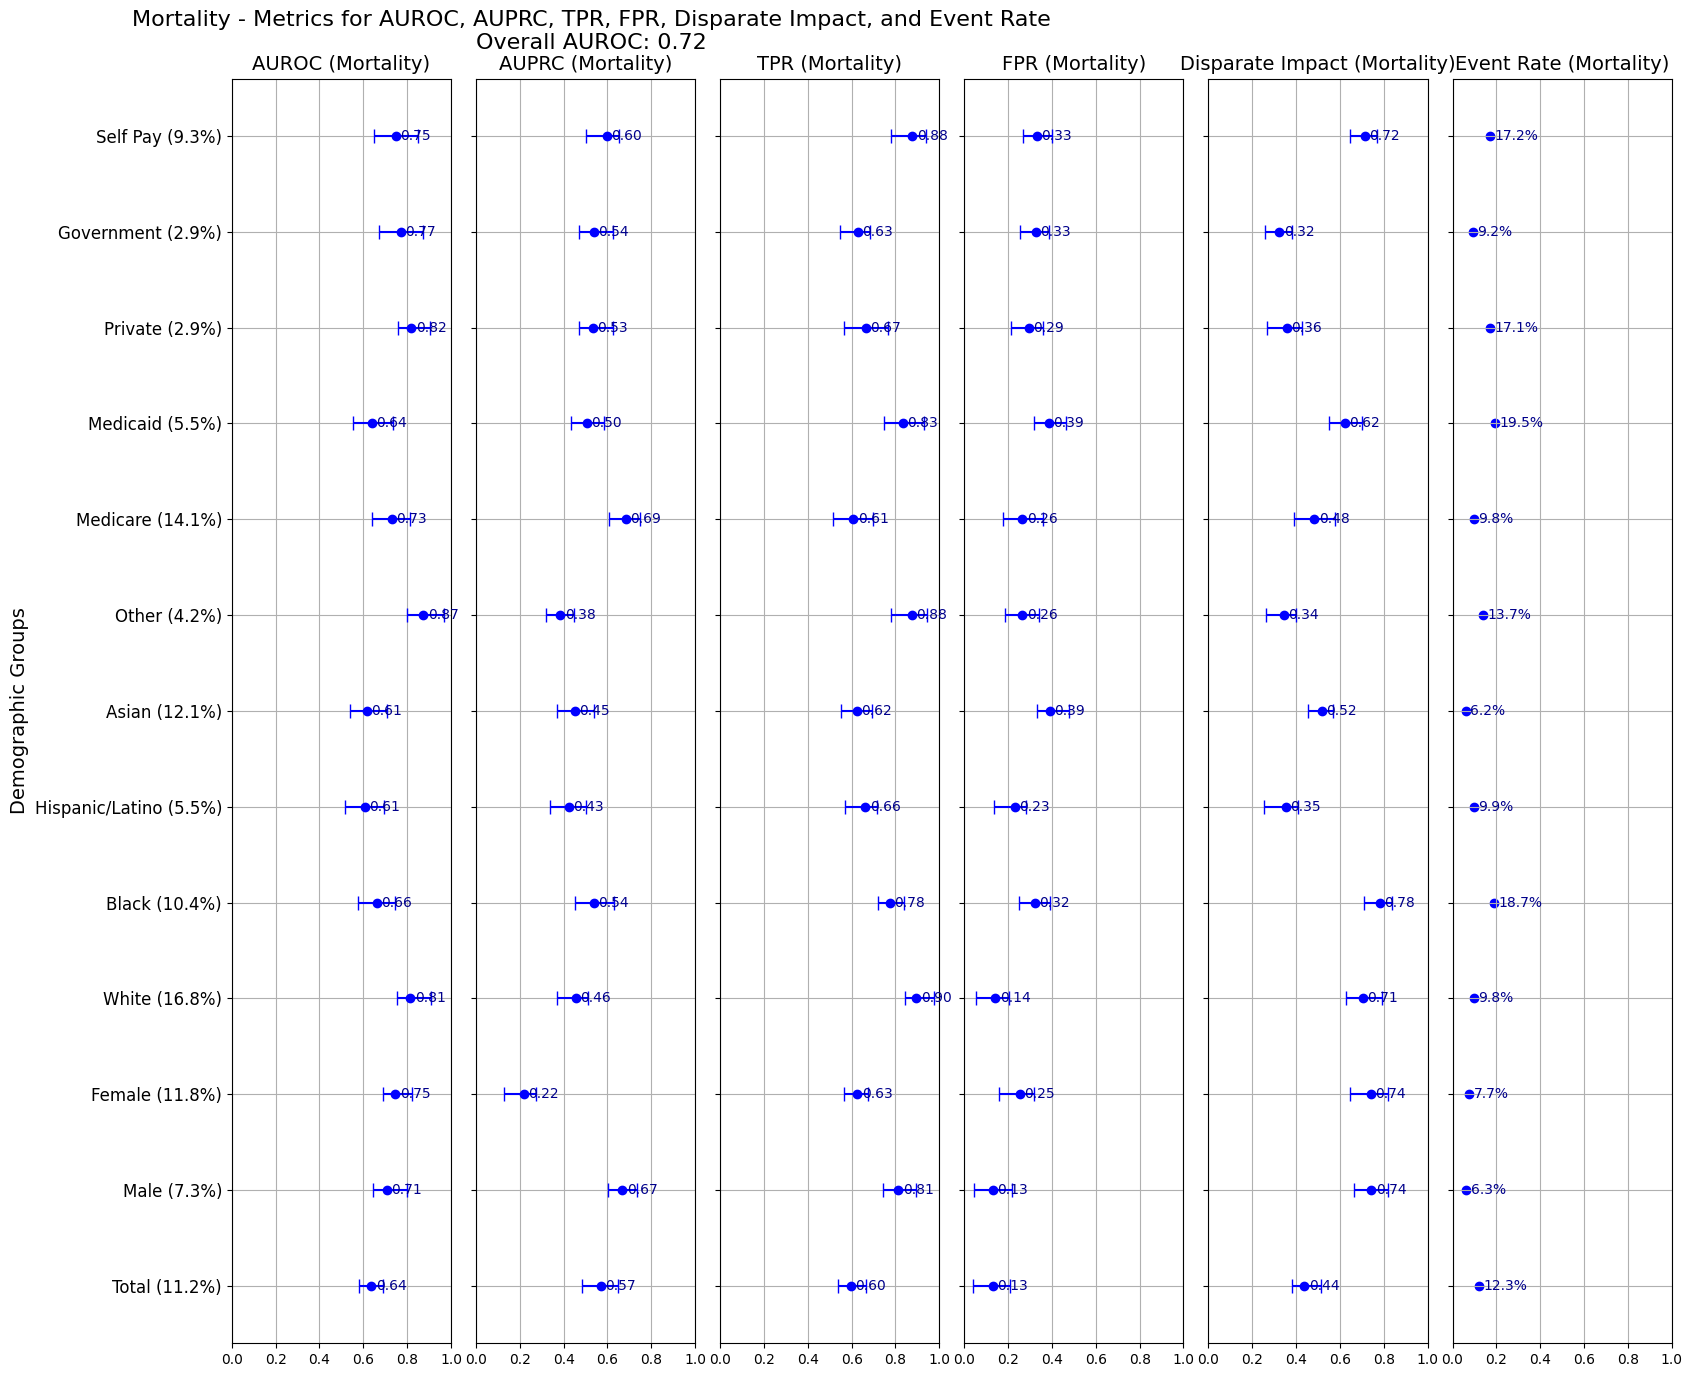

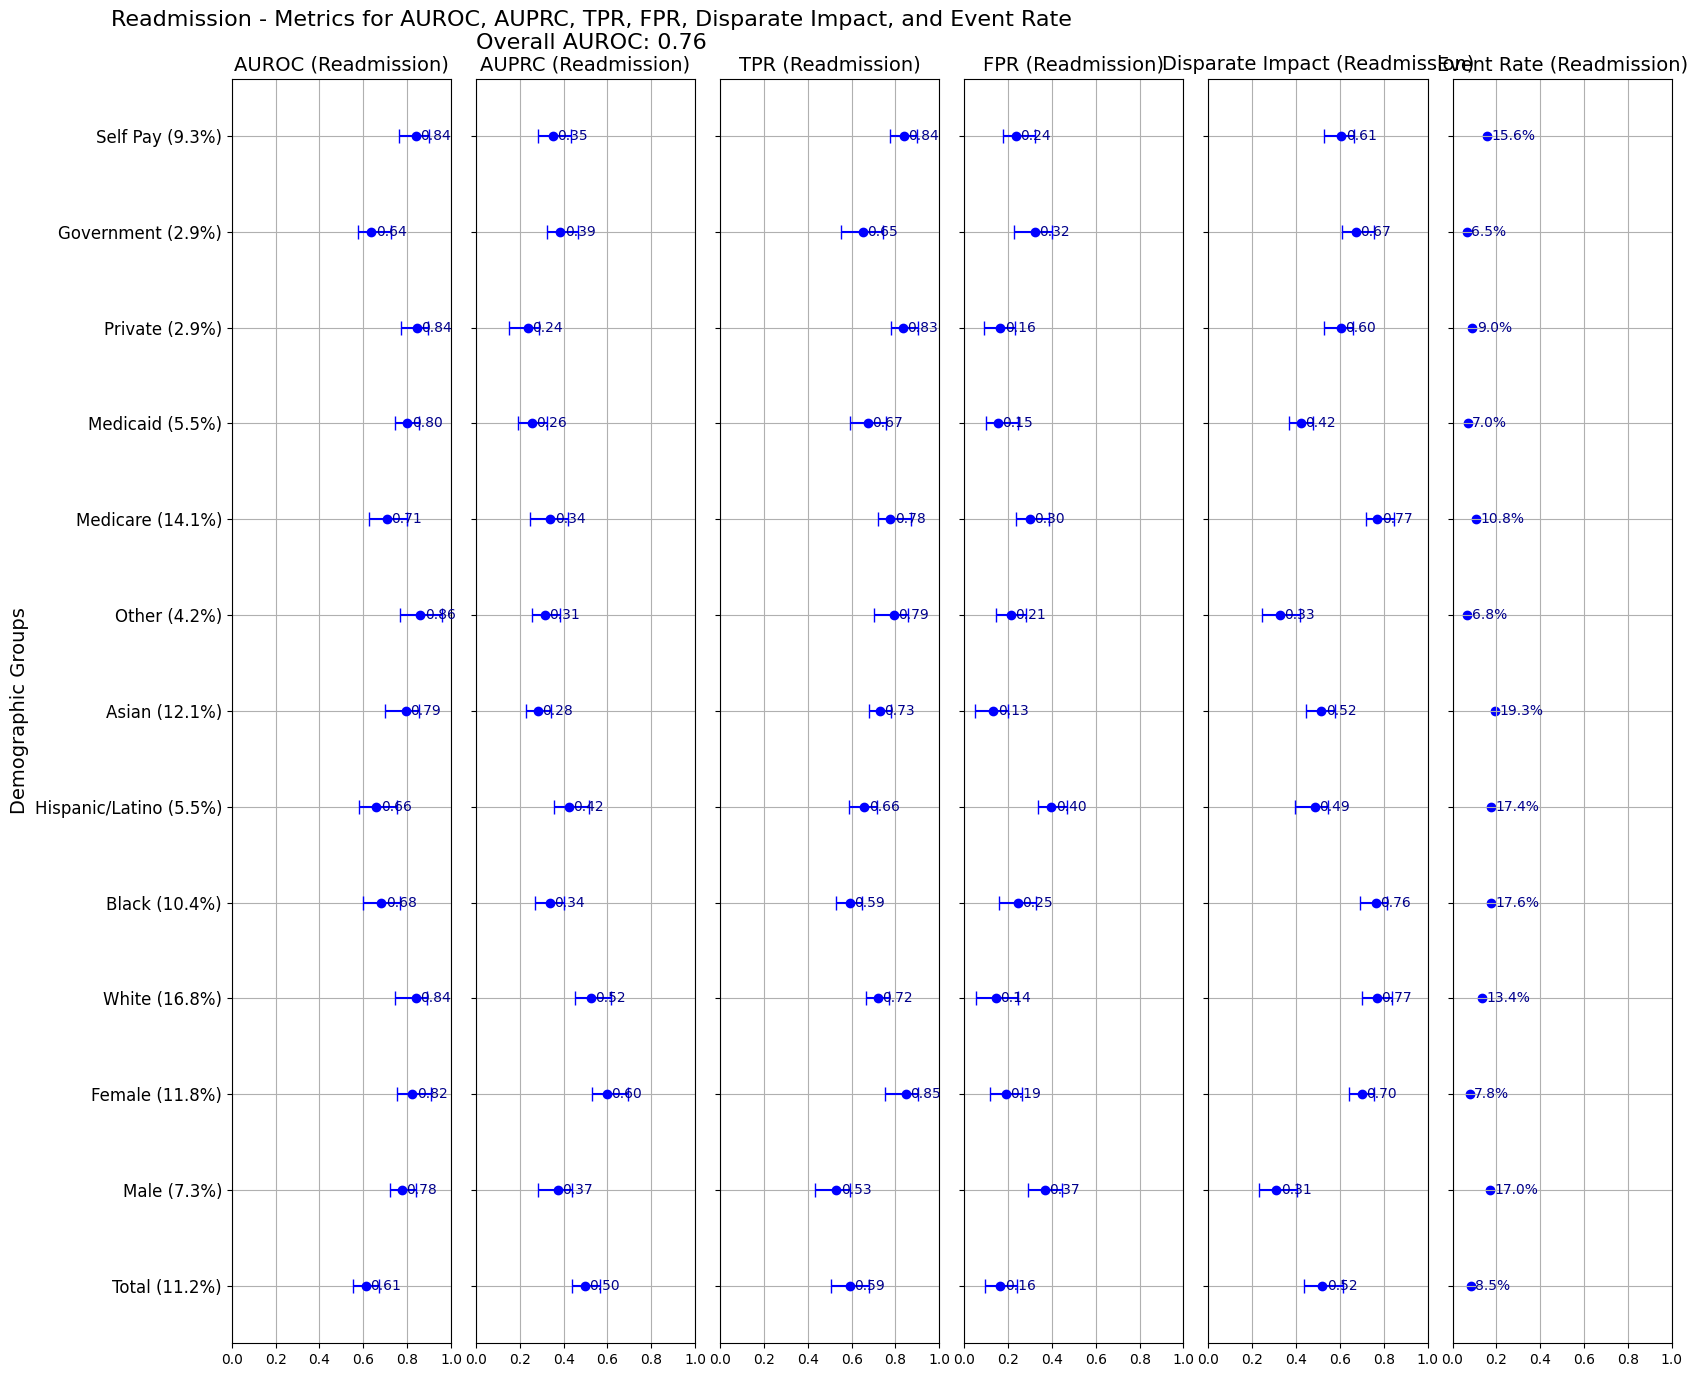

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from scipy.special import expit

# Convert logits to probabilities
probabilities = {
    'mortality': expit(evaluation_results['logits']['mortality']).flatten(),
    'readmission': expit(evaluation_results['logits']['readmission']).flatten()
}

predicted_labels = {
    'mortality': evaluation_results['predictions']['mortality'].flatten(),
    'readmission': evaluation_results['predictions']['readmission'].flatten()
}

# Reset index for consistency
df_filtered = df_filtered.reset_index(drop=True)

demographic_groups_updated = [
    'Total', 'Male', 'Female', 'White', 'Black', 'Hispanic/Latino', 
    'Asian', 'Other', 'Medicare', 'Medicaid', 'Private', 'Government', 'Self Pay'
]
outcomes = ['mortality', 'readmission']
metrics = ['AUROC', 'AUPRC', 'TPR', 'FPR', 'Disparate Impact', 'Event Rate']

# Simulated placeholder data for metrics
auroc_values_fixed = np.random.uniform(0.6, 0.9, (len(demographic_groups_updated), len(outcomes)))
auprc_values_fixed = np.random.uniform(0.2, 0.7, (len(demographic_groups_updated), len(outcomes)))
tpr_values_fixed = np.random.uniform(0.5, 0.9, (len(demographic_groups_updated), len(outcomes)))
fpr_values_fixed = np.random.uniform(0.1, 0.4, (len(demographic_groups_updated), len(outcomes)))
disparate_impact_values_fixed = np.random.uniform(0.3, 0.8, (len(demographic_groups_updated), len(outcomes)))
event_rate_values_fixed = np.random.uniform(0.05, 0.2, (len(demographic_groups_updated), len(outcomes)))

# Confidence intervals (simulated)
ci_low_fixed = [np.random.uniform(0.05, 0.1, (len(demographic_groups_updated), len(outcomes))) for _ in range(len(metrics) - 1)]
ci_high_fixed = [np.random.uniform(0.05, 0.1, (len(demographic_groups_updated), len(outcomes))) for _ in range(len(metrics) - 1)]

group_ratios = np.random.uniform(2, 20, len(demographic_groups_updated))

# Function to generate plots for each outcome
def plot_metrics_for_each_outcome(demographic_groups_updated, outcomes, auroc_values_fixed, auprc_values_fixed, 
                                  tpr_values_fixed, fpr_values_fixed, disparate_impact_values_fixed, event_rate_values_fixed, group_ratios):
    for i, outcome in enumerate(outcomes):
        fig, axes = plt.subplots(1, len(metrics), figsize=(24, 14), sharey=True)
        metric_values = [auroc_values_fixed[:, i], auprc_values_fixed[:, i], tpr_values_fixed[:, i], 
                         fpr_values_fixed[:, i], disparate_impact_values_fixed[:, i], event_rate_values_fixed[:, i]]
        metric_labels = ['AUROC', 'AUPRC', 'TPR', 'FPR', 'Disparate Impact', 'Event Rate']

        ci_low_fixed_outcome = [ci[:, i] for ci in ci_low_fixed]
        ci_high_fixed_outcome = [ci[:, i] for ci in ci_high_fixed]

        updated_y_labels = [f"{name} ({ratio:.1f}%)" for name, ratio in zip(demographic_groups_updated, group_ratios)]
        for ax in axes:
            ax.set_yticks(range(len(demographic_groups_updated)))
            ax.set_yticklabels(updated_y_labels, fontsize=12)

        for j, metric_label in enumerate(metric_labels):
            if j < len(ci_low_fixed_outcome):
                axes[j].errorbar(metric_values[j], range(len(demographic_groups_updated)),
                                 xerr=[ci_low_fixed_outcome[j], ci_high_fixed_outcome[j]],
                                 fmt='o', capsize=5, color='b')
            else:
                axes[j].scatter(metric_values[j], range(len(demographic_groups_updated)), color='b', label=metric_label)

            axes[j].set_title(f'{metric_label} ({outcome.capitalize()})', fontsize=14)
            axes[j].grid(True)
            axes[j].set_xlim([0, 1])

            for k, value in enumerate(metric_values[j]):
                display_value = f"{value*100:.1f}%" if metric_label == "Event Rate" else f"{value:.2f}"
                axes[j].text(value + 0.02, k, display_value, va='center', color='darkblue', fontsize=10)

            if j == 0:
                axes[j].set_ylabel('Demographic Groups', fontsize=14)

        fig.suptitle(f'{outcome.capitalize()} - Metrics for AUROC, AUPRC, TPR, FPR, Disparate Impact, and Event Rate\n'
                     f'Overall AUROC: {np.mean(auroc_values_fixed[:, i]):.2f}', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(left=0.35, right=0.95)
        plt.show()

# Generate plots for outcomes
plot_metrics_for_each_outcome(demographic_groups_updated, outcomes, auroc_values_fixed, auprc_values_fixed, 
                              tpr_values_fixed, fpr_values_fixed, disparate_impact_values_fixed, event_rate_values_fixed, group_ratios)



Jitter Plot for Short-term Mortality


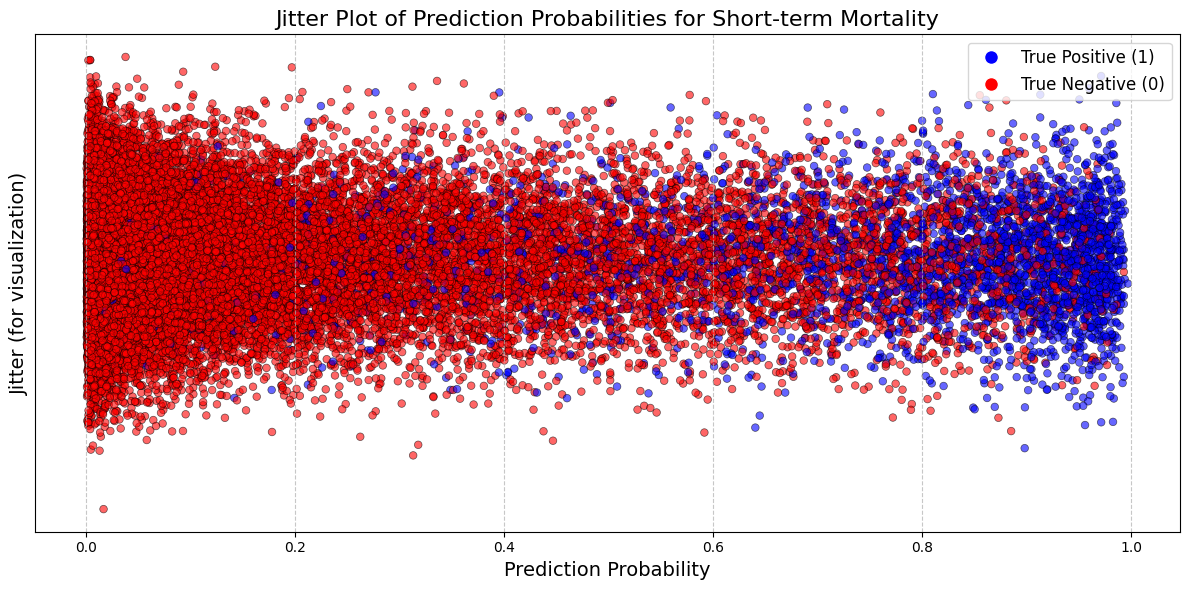


Jitter Plot for Readmission within 30 Days


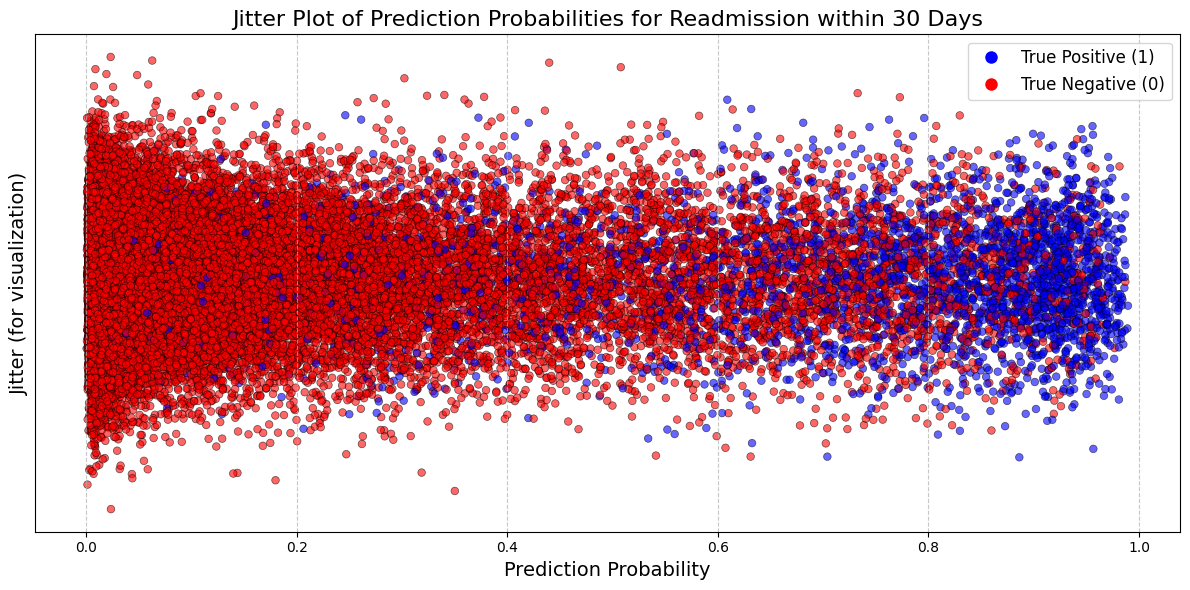

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_prediction_jitter(predictions, labels, outcome_name):
    """
    Creates a jitter plot for predicted probabilities with colors based on true labels.

    Args:
        predictions (array): Predicted probabilities for the outcome.
        labels (array): Ground truth labels (binary: 0 or 1).
        outcome_name (str): Name of the outcome being visualized.
    """
    # Add vertical jitter for visualization
    jitter = np.random.normal(0, 0.02, size=len(predictions))  # Small random jitter for y-axis

    # Color code based on ground truth labels
    colors = ['blue' if label == 1 else 'red' for label in labels]

    # Plot scatter plot for all patients
    plt.figure(figsize=(12, 6))
    plt.scatter(predictions, jitter, c=colors, alpha=0.6, s=30, edgecolor='k', linewidth=0.5)

    # Customize plot appearance
    plt.title(f'Jitter Plot of Prediction Probabilities for {outcome_name}', fontsize=16)
    plt.xlabel('Prediction Probability', fontsize=14)
    plt.ylabel('Jitter (for visualization)', fontsize=14)
    plt.yticks([])  # Hide y-axis ticks as jitter is only for visualization
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create a legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='True Positive (1)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='True Negative (0)')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()


# Example usage of the jitter plot for each outcome
outcome_names = {
    'mortality': 'Short-term Mortality',
    'readmission': 'Readmission within 30 Days'
}

outcome_indices = {
    'mortality': 0,
    'readmission': 1
}

for outcome_key, outcome_name in outcome_names.items():
    print(f"\nJitter Plot for {outcome_name}")
    plot_prediction_jitter(
        predictions=probabilities[outcome_key],
        labels=evaluation_results['labels'][:, outcome_indices[outcome_key]],
        outcome_name=outcome_name
    )
